Data Science Revealed by Tshepo Chris Nokeri, Apress. 2021

# Chapter 4: Discover Market Regime

This chapter presents a widespread generative probabilistic model recognized as the Hidden Markov Model (HMM). It carefully conceals effective techniques for identifying hidden patterns in time series data using the HMM and generating a sequence of observations. After referring to the contents of this chapter, you must be able to design and develop HMM with a Gaussian process to discover market regimes. To install hmmlearn in the Python environment, we pip install hmmlearn and on the conda environment we use conda install -c conda-forge hmmlearn

# Import Dependencies

In [1]:
import datetime
import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import scale
import pandas_datareader as data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("talk","ticks",font_scale=1,font="Calibri")
from pylab import rcParams
plt.rcParams["figure.dpi"] = 300
import warnings
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator


In [2]:
ticker = "^GSPC"
start_date = datetime.date(2010, 7, 1)
end_date = datetime.date.today()
df = data.DataReader(ticker, 'yahoo', start_date, end_date)

# Data Preprocessing

In [3]:
df.reset_index(inplace=True,drop=False)
df.drop(['Open','High','Low','Adj Close'],axis=1,inplace=True)
df['Date'] = df['Date'].apply(datetime.datetime.toordinal)
df = list(df.itertuples(index=False, name=None))

In [4]:

dates = np.array([q[0] for q in df], dtype=int)
end_val = np.array([q[1] for q in df])
volume = np.array([q[2] for q in df])[1:]

In [5]:
diff = np.diff(end_val)
dates = dates[1:]
end_val = end_val[1:]


## Original Series

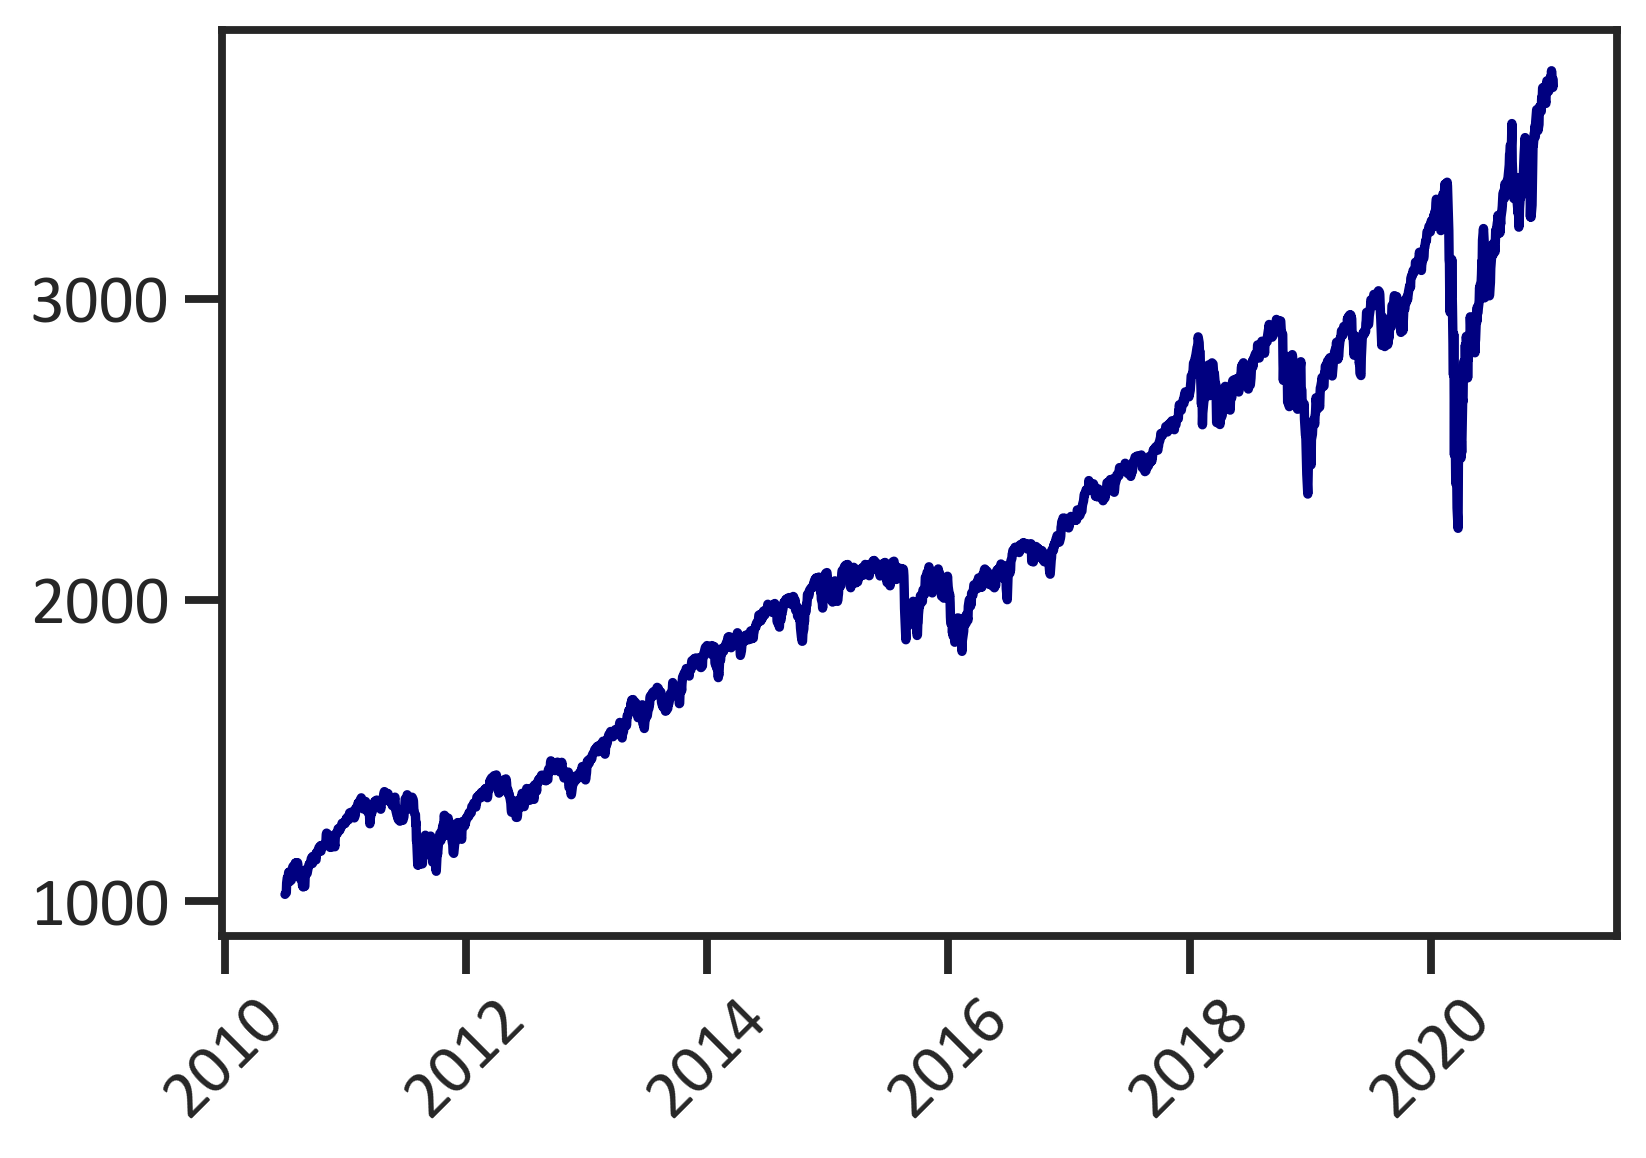

In [6]:
X = np.column_stack([diff, volume])
plt.plot_date(dates,end_val,"-",color="navy")
plt.xticks(rotation=45)
plt.show()

## Develop GaussianHMM

In [7]:

model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

## Hidden States

In [8]:
hidden_states = model.predict(X)

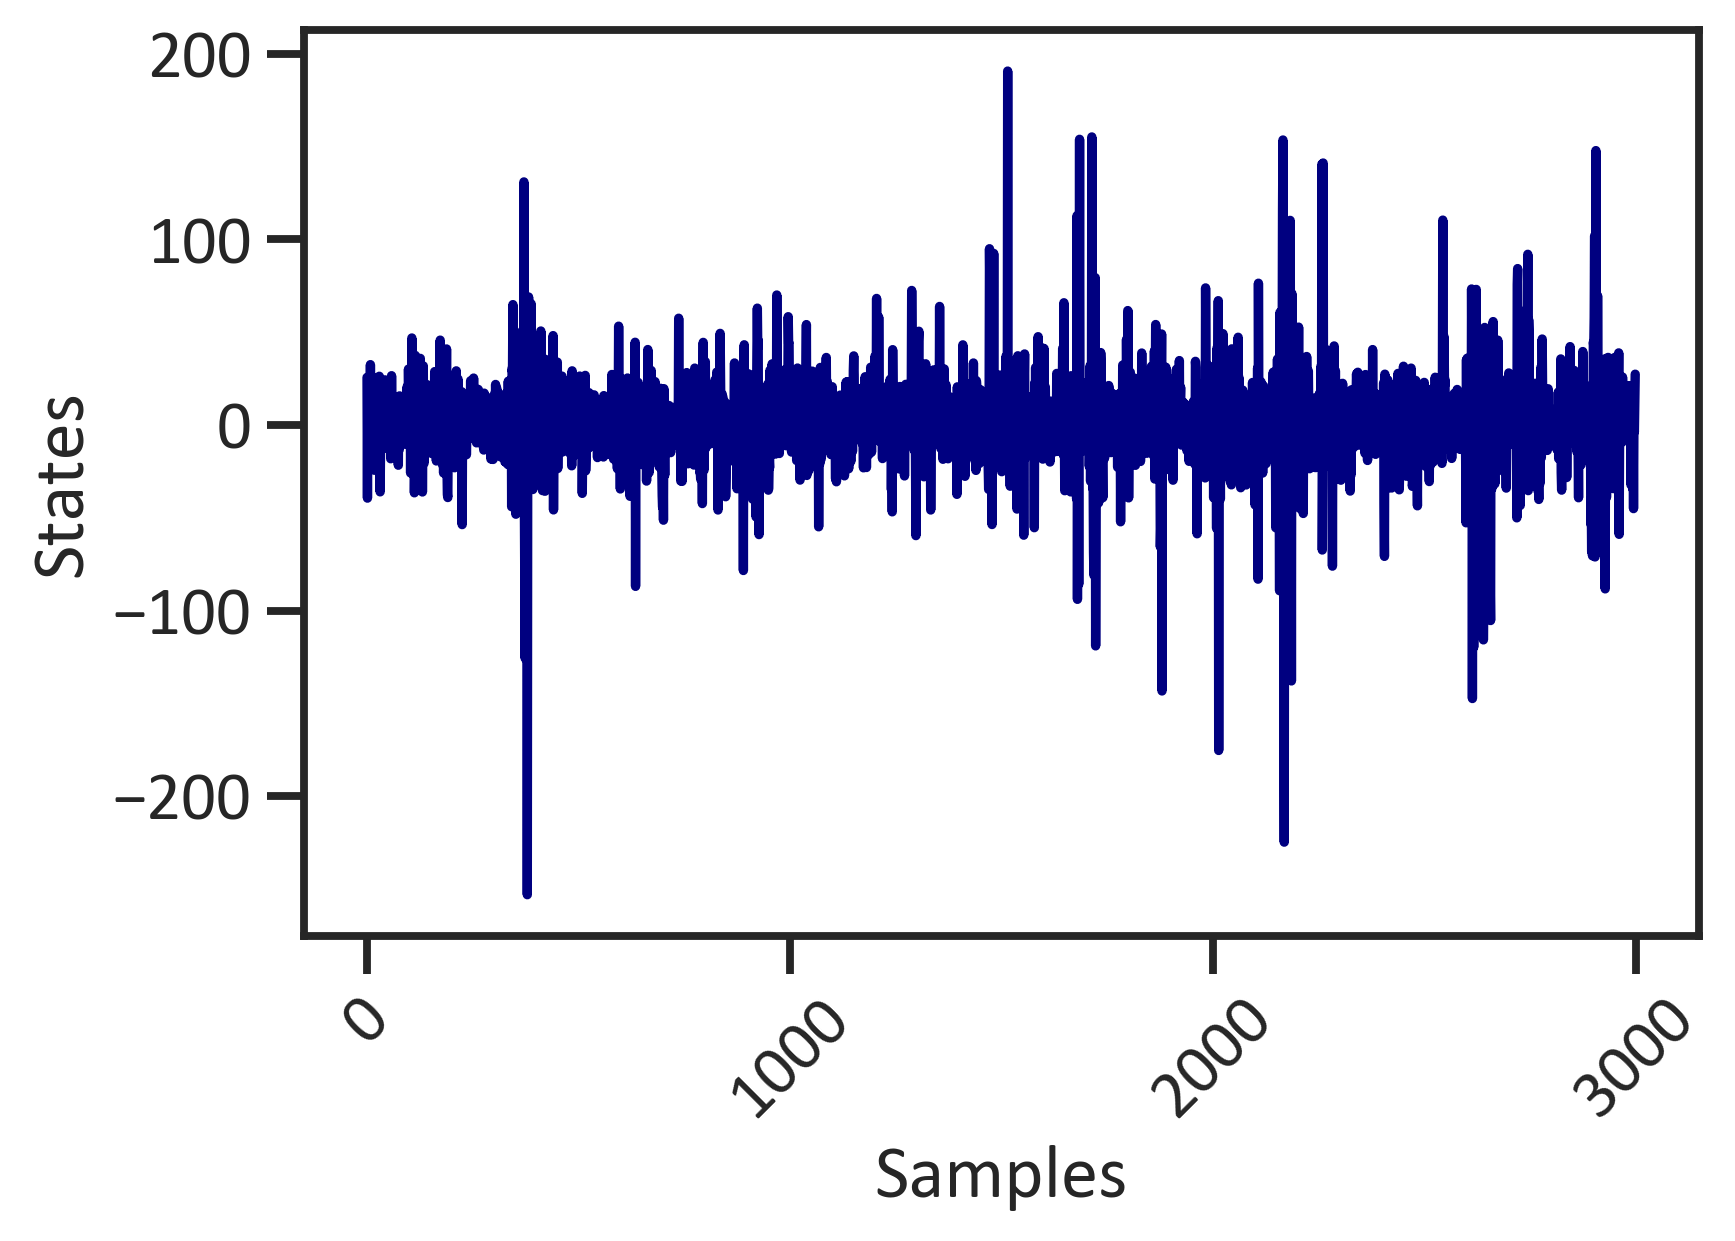

In [9]:
num_sample = 3000
sample, _ = model.sample(num_sample)
plt.plot(np.arange(num_sample), sample[:,0],color="navy")
plt.xlabel("Samples")
plt.ylabel("States")
plt.xticks(rotation=45)
plt.show()

## Trainsition Matrix and Mean-VARs

In [10]:
print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()


Transition matrix
[[8.66382871e-01 3.67109709e-02 6.01949196e-04 9.63042091e-02]
 [9.61349343e-02 8.84630508e-01 1.37115064e-19 1.92345579e-02]
 [3.32562608e-06 7.39942180e-04 8.38745151e-01 1.60511581e-01]
 [1.80222192e-01 1.81660471e-02 2.94114334e-02 7.72200328e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [2.35625243e+00 3.56863705e+09]
var =  [1.67919759e+02 1.05762680e+17]

1th hidden state
mean =  [1.42168444e+00 2.89951778e+09]
var =  [9.28058130e+01 2.46957641e+17]

2th hidden state
mean =  [-8.41146455e+00  5.92924906e+09]
var =  [6.93718842e+03 1.83980348e+18]

3th hidden state
mean =  [-2.82737764e-02  4.37802824e+09]
var =  [7.10082024e+02 3.69713993e+17]



## Visualize Hidden States

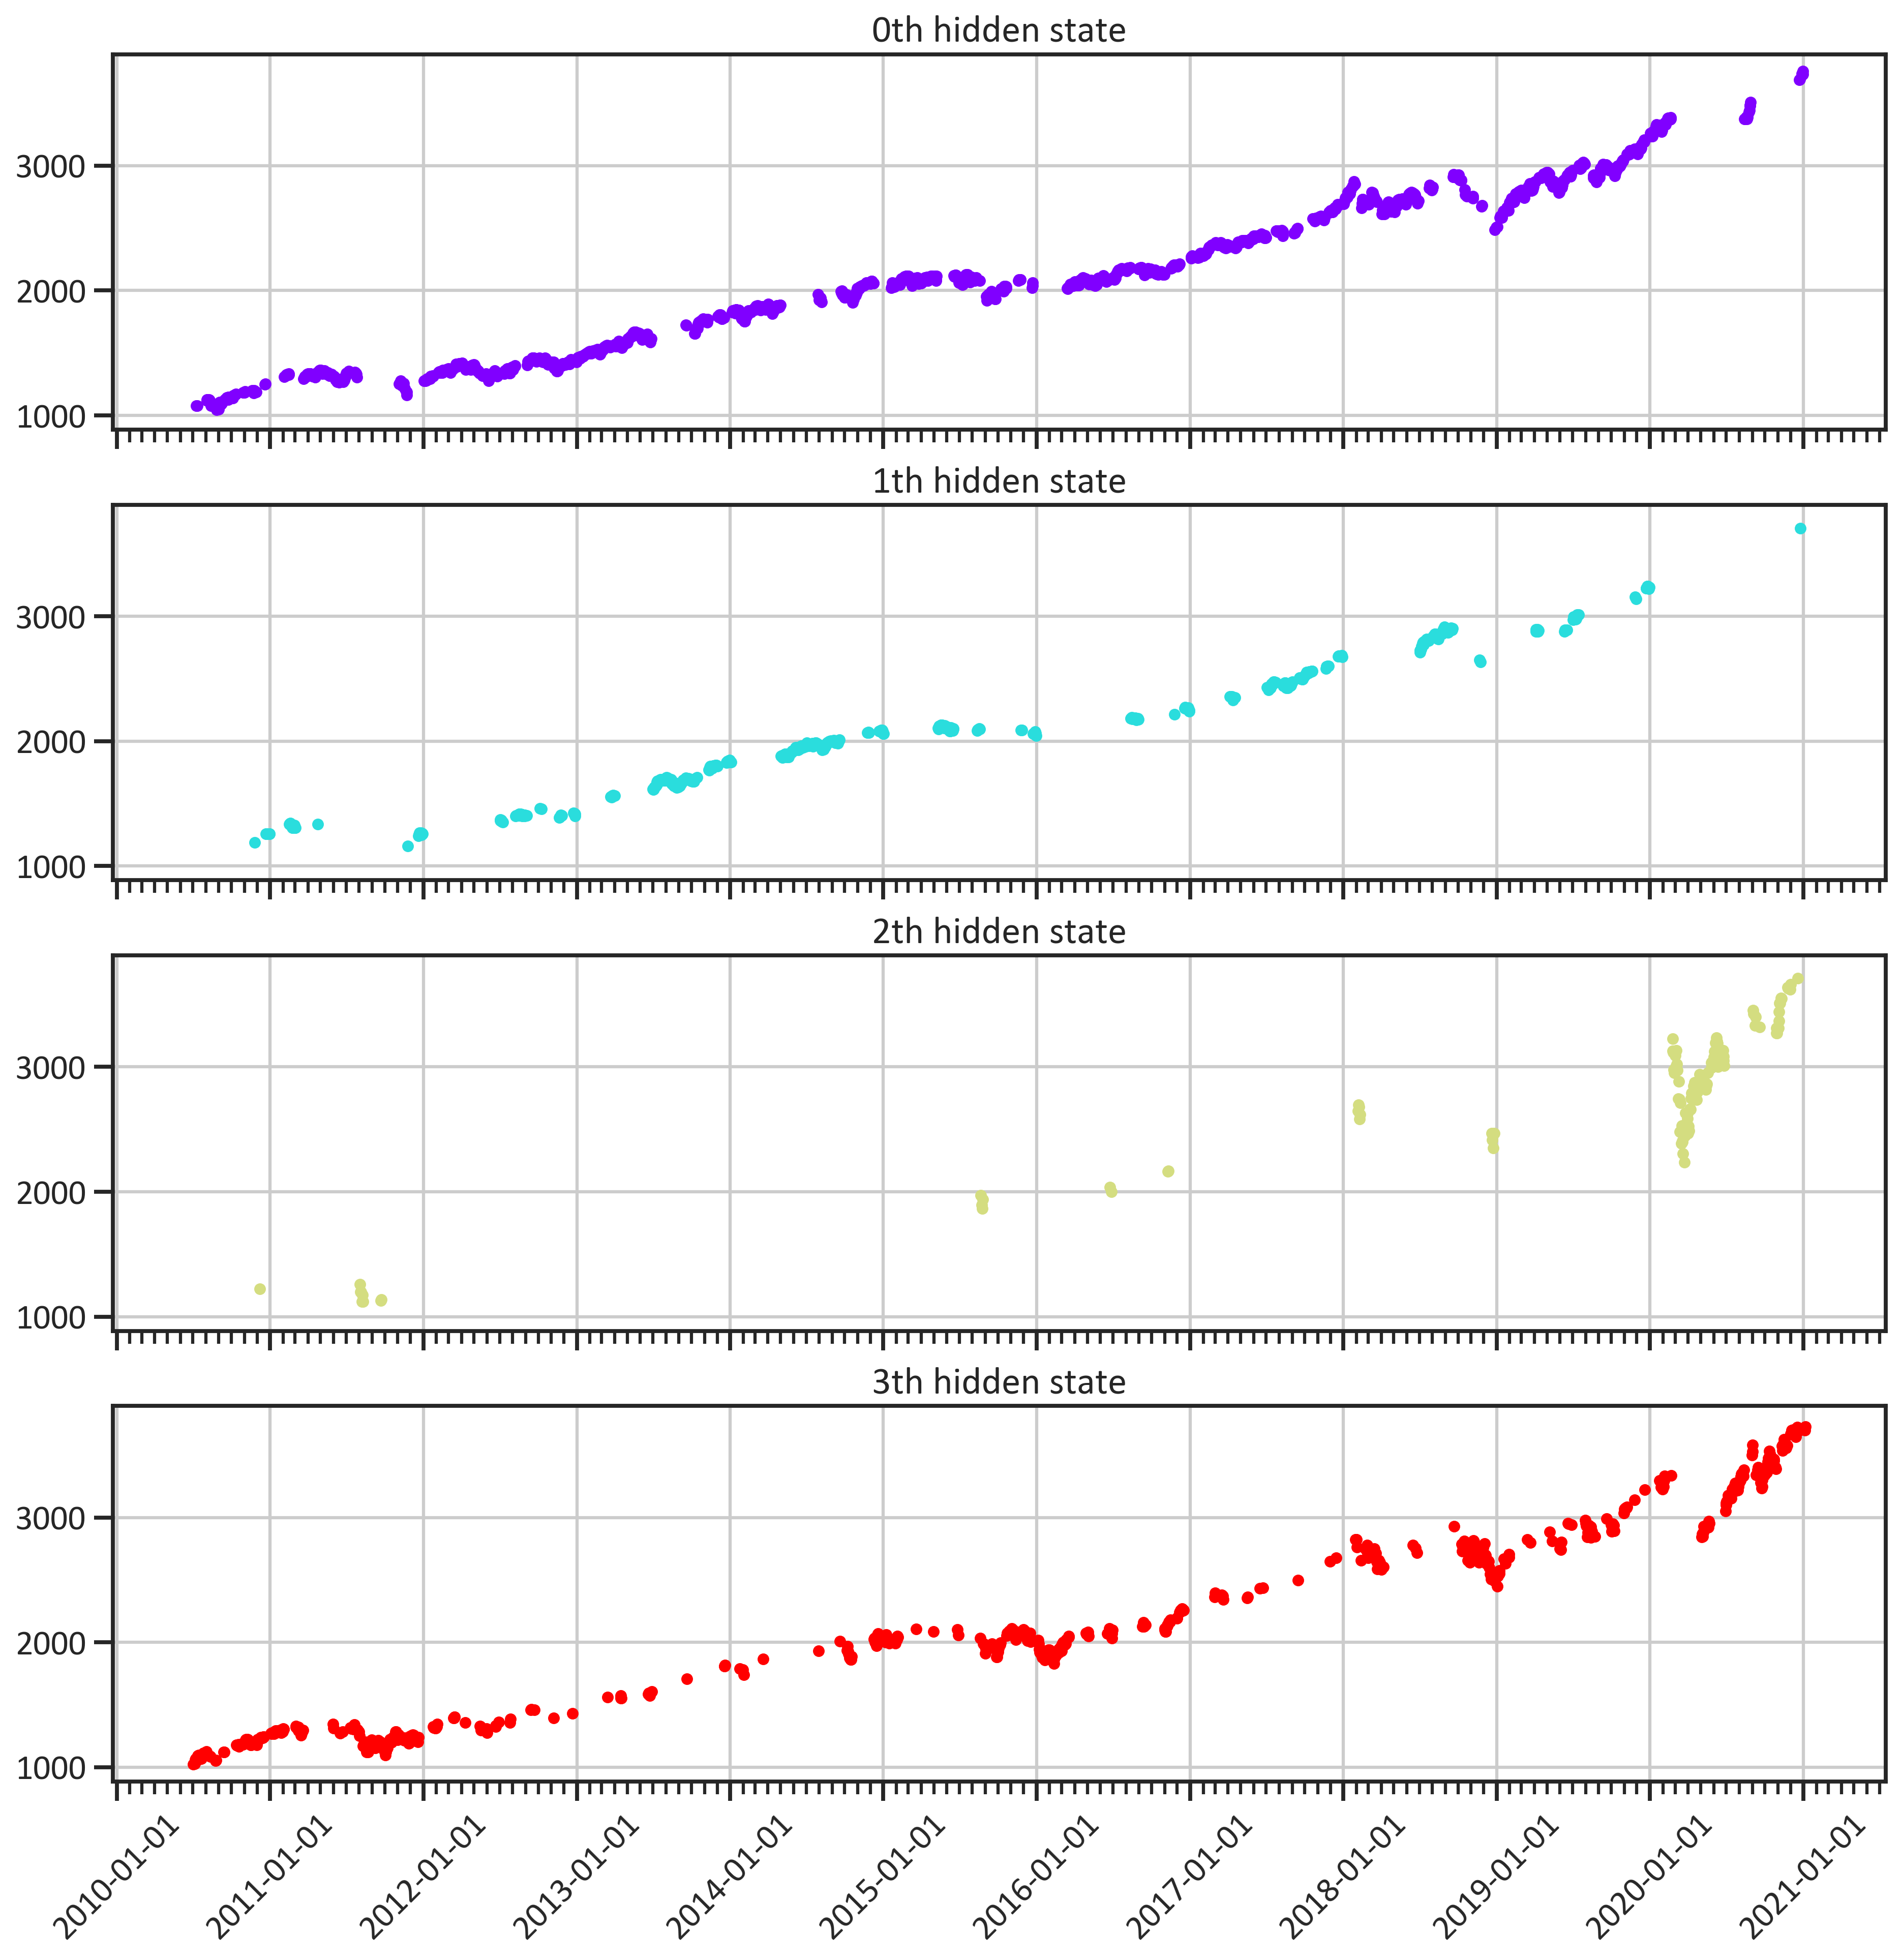

In [11]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = hidden_states == i
    ax.plot_date(dates[mask], end_val[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    ax.grid(True)
plt.xticks(rotation=45)
plt.show()

## Return and Volume

In [12]:
import pandas as pd
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)

    Returns        Volume
0  2.085822  3.623442e+09
1  1.483640  2.992282e+09
2 -7.058554  5.678010e+09
3  0.181249  4.250923e+09


In [13]:
import datetime
lastN = 7
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) 

dates = np.array([q[0] for q in df], dtype=int)

## Compare Actual and Predicted Values

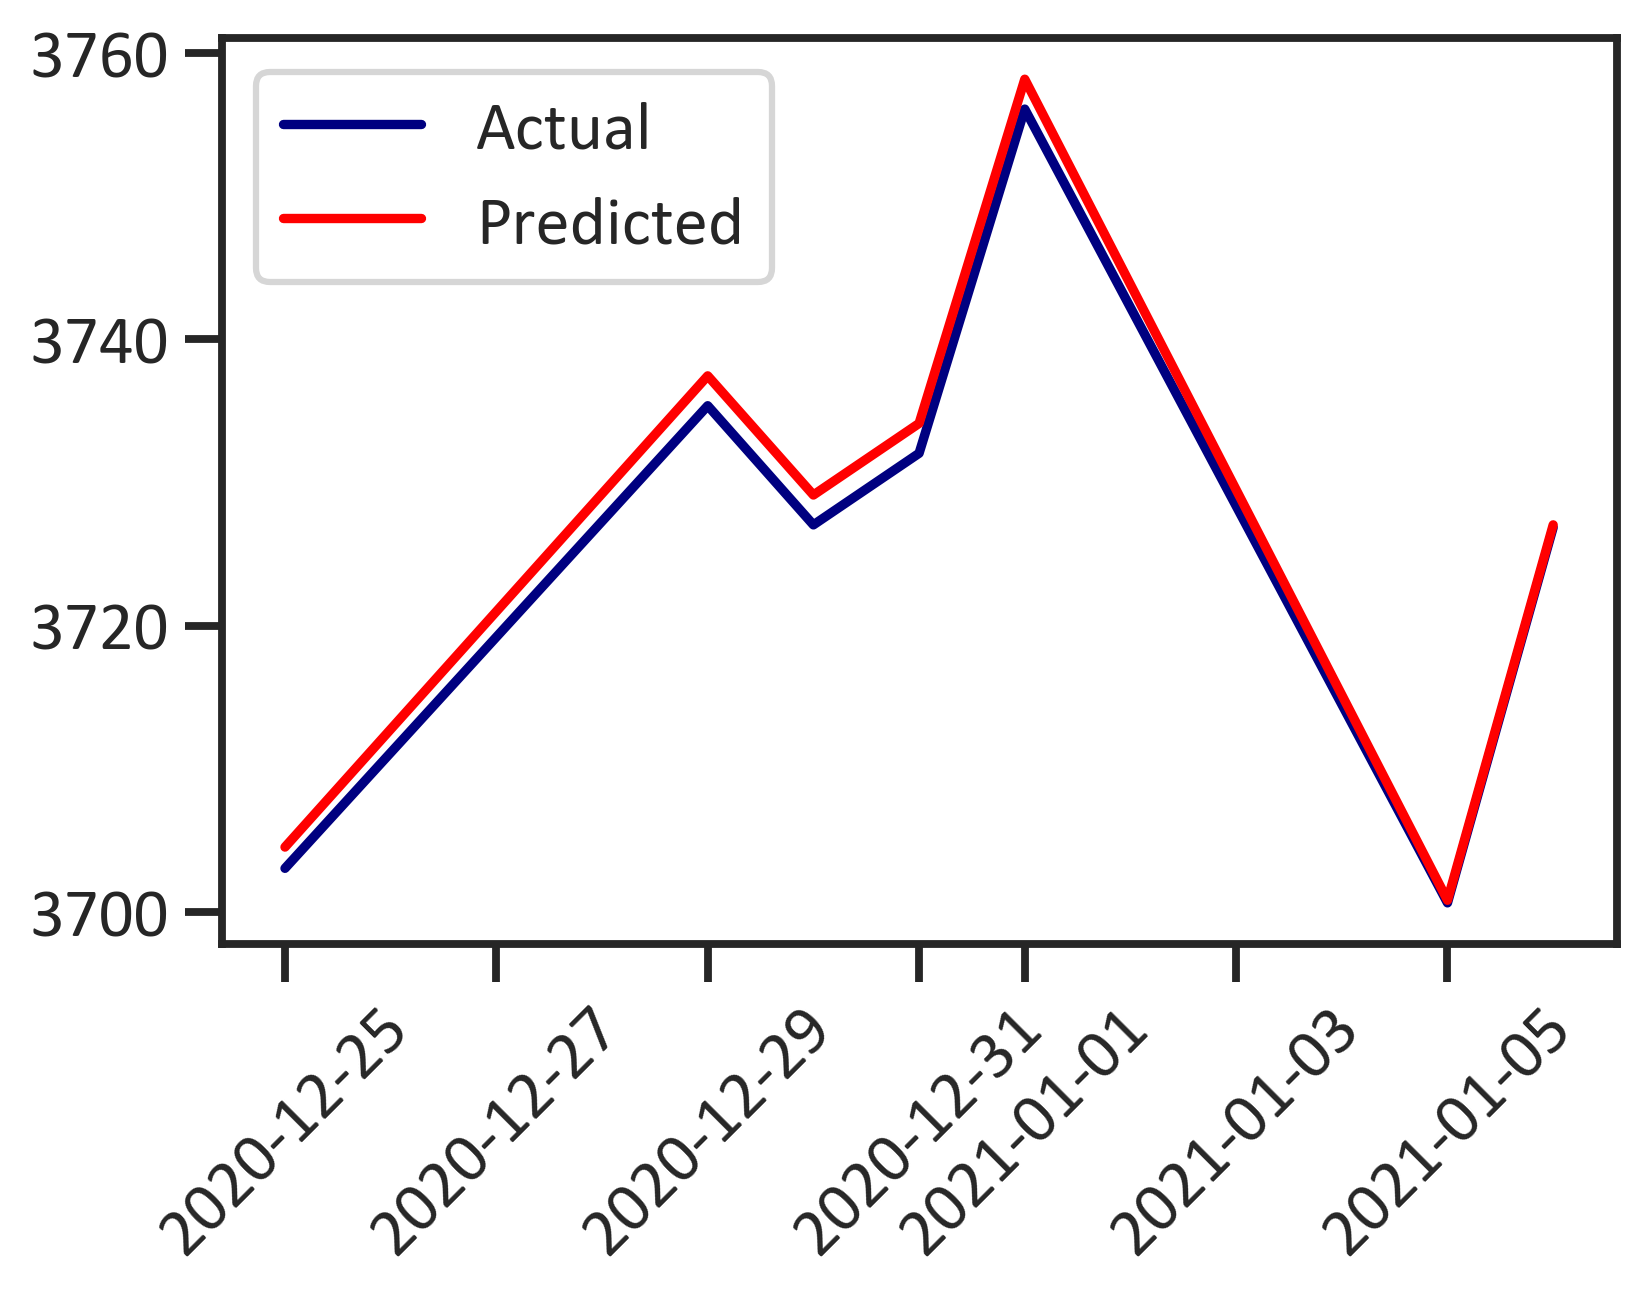

In [14]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []
for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = df[-lastN+idx][1]
    volume = df[-lastN+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    
plt.plot(predicted_dates,end_val[-lastN:],color="navy")
plt.plot(predicted_dates,predicted_prices,color="red")
plt.legend(['Actual','Predicted'])
plt.xticks(rotation=45)
plt.show()

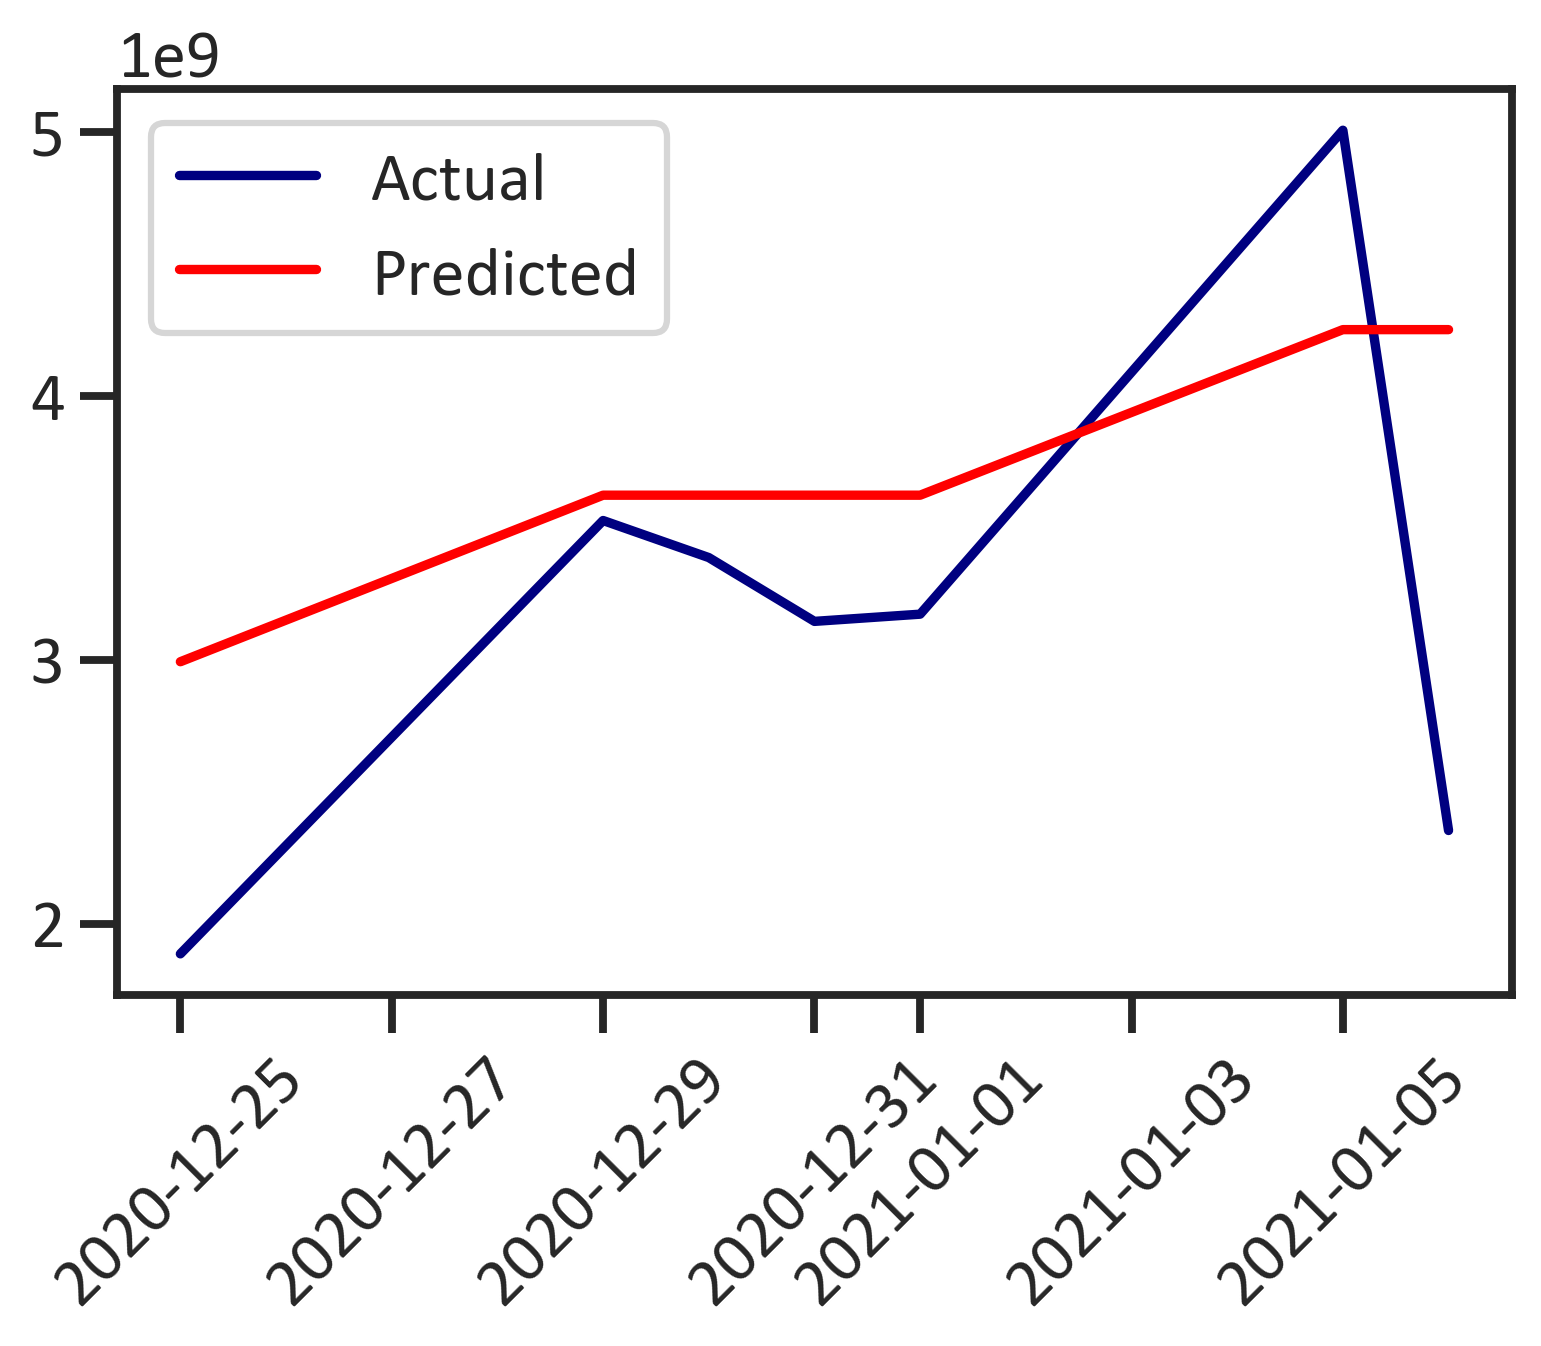

In [15]:
plt.plot(predicted_dates,actual_volumes, color="navy")
plt.plot(predicted_dates,predicted_volumes, color="red")
plt.legend(['Actual','Predicted'])
plt.xticks(rotation=45)
plt.show()